# Primary Sensitivity Panel Plots

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Figs. 7, 10, 12, 15

In [1]:
# Import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import xarray as xr
import pandas as pd

# Import authored modules
import centered_response as cr
from wofunits import wofunits
from wofs_colortables import cb_colors

# To suppress warnings
import logging

# Set paths
wofs_path = wofunits.paths['wofs_path'] # WoFS data path
sens_path = wofunits.paths['sens_path'] # sensitivity data path
sm_path = wofunits.paths['sm_path'] # storm motion CSV path
outplot_path = wofunits.paths['outplot_path'] # plot save path

# Primary sensitivity panelplots (Figs. 7, 10, 12, 15)

## Manually set case, time, inflow domain specs, etc. for the desired plotting

In [2]:
# Set case/plotting specs
#case = '201905172200'
#case = '201905202030'
#case = '201905262000'
case = '201905282230'

respvar = 'UH25-30MIN'
statevars = ['T2','U10','SHEAR-TOT1','SRH1-TRUE']
save = True

################################# Define universal plotting specs ##########################################

xlimleft, xlimright = -40,60
ylimleft, ylimright = -60,50

levels = np.arange(-60,61,10)
ticks = levels[0::4]

axlabels = ['a)','b)','c)','d)','e)','f)','g)','h)']

## Plot Figs. 7, 10, 12, 15:  Long vs. Short Lead-Time Sensitivity Panels

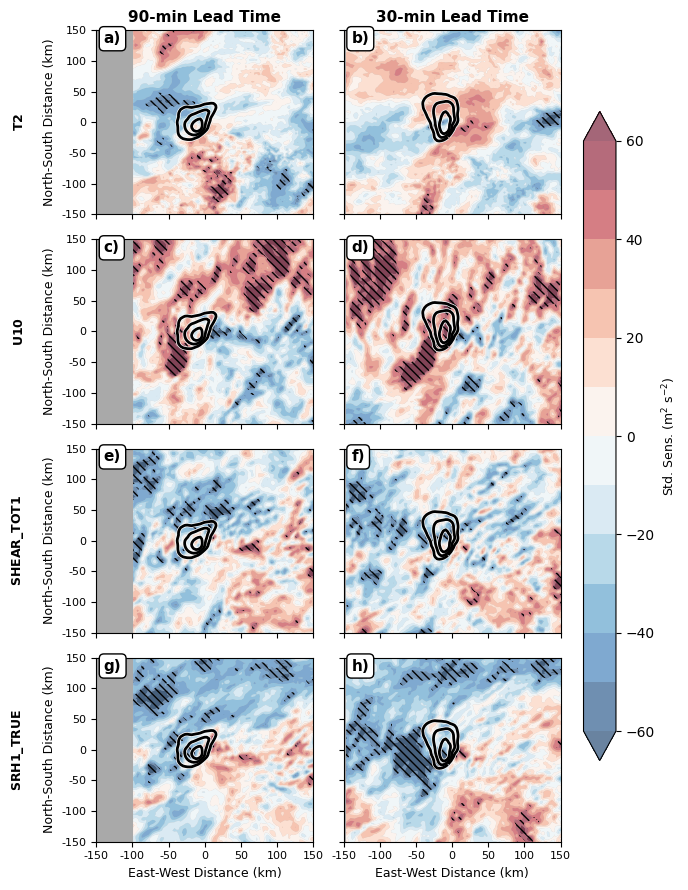

In [3]:

wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

statevars = np.concatenate([np.array([statevar]*2) for statevar in statevars]).tolist()[:len(statevars)*2]

if case == '201905262000':
    state_times = [state_times[-5], state_times[-3]]*int(len(statevars)/2)
else:
    state_times = [state_times[-7], state_times[-3]]*int(len(statevars)/2)

################################# Define figure and plot ##########################################

fig, axs = plt.subplots(4, 2,figsize=(7,9))
axs = axs.flatten()

for i, ax in enumerate(axs):

    state_time = state_times[i]
    statevar = statevars[i]

    ############### Process date/time strings and define file names ################
    
    respmin, resphour, respday, respmonth, respyear = resptime[14:16], resptime[11:13], resptime[8:10], resptime[5:7], resptime[0:4]
    str_statemin, str_statehour, str_statemonth = '{:02d}'.format(state_time.minute),'{:02d}'.format(state_time.hour),'{:02d}'.format(state_time.month)
    inityear, initmin, inithour, initday, initmonth = case[0:4], case[10:12], case[8:10], case[6:8], case[4:6]
    
    resp_time = datetime.datetime(int(respyear), int(respmonth), int(respday), int(resphour), int(respmin))
    
    file_ref = f'{wofs_path}/wofs_{inityear}{initmonth}{initday}_{inithour}{initmin}/wofs_center_i{inityear}{initmonth}{initday}{inithour}{initmin}_v{state_time.year}{str_statemonth}{state_time.day}{str_statehour}{str_statemin}.nc'
    file_sens = f'{sens_path}/sens_center_2019{initmonth}{initday}{inithour}{initmin}/stats_{respvar}_max_{resphour}_{respmin}_00_{statevar}_{str_statehour}_{str_statemin}_00.nc'
        
    ############### Open files and define variables from them ################
    
    ds_ref = xr.open_dataset(file_ref)
    ds_sens = xr.open_dataset(file_sens)

    cref = np.where(np.nanmean(ds_ref.REFD_MAX, axis=0) < 10, np.nan, np.nanmean(ds_ref.REFD_MAX, axis=0))[0]
    sens = ds_sens.stdsens
    pstat = abs(ds_sens['pstat'].values)
    
        # remove where sensitivity is infinity
    sens = np.where(sens==9.96921e+36, np.nan, sens)
    
    ############### Define storm-relative grids ################
    
    logging.captureWarnings(True) # suppress warnings
    
    df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)
    
    xmesh,ymesh = cr.xy_mesh(case, state_time)
    
    logging.captureWarnings(False) # turn warnings back on
    
    ############### Plotting code ################
    
    ax.contour(xmesh, ymesh, cref, linewidths=3, levels=[20,35,50], colors='w', alpha=1)
    ax.contour(xmesh, ymesh, cref, linewidths=2, levels=[20,35,50], colors='k')
    ax.contourf(xmesh, ymesh, sens, colors='white', levels=levels, antialiased=True) # prevents dark background from bleeding through
    cb = ax.contourf(xmesh, ymesh, sens, cmap='RdBu_r', levels=levels, extend='both', antialiased=True, alpha=0.6)
    ax.contourf(xmesh, ymesh, pstat, [0, 0.05], colors='none', hatches=['\\\\\\\\'], extend='lower')
    
    ax.set_facecolor('darkgrey') # make axis background gray
    
    ax.set_xlim(-150,150)
    ax.set_ylim(-150,150)
    
    ########## Axis decoration specs ##########
    
    statevar = statevar.replace('-', '\_')
    
    xticks, yticks = np.arange(-150,151,50), np.arange(-150,151,50)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    if i in [6,7]:
        ax.set_xlabel('East-West Distance (km)', size=9)
        ax.set_xticklabels(xticks, size=8)
    else:
        ax.set_xticklabels([])
    
    if (i % 2) == 0: # if divisible by 3
        ax.set_ylabel(r'$\bf{' + statevar + '}$\n\n' + 'North-South Distance (km)', size=9)
        ax.set_yticklabels(yticks, size=8)
    else:
        ax.set_yticklabels([])

    if i == 0:
        if case == '201905262000':
            ax.set_title('60-min Lead Time', size=11, weight='bold')
        else:
            ax.set_title('90-min Lead Time', size=11, weight='bold')
    if i == 1:
        ax.set_title('30-min Lead Time', size=11, weight='bold')
    
    ax.text(0.035, 0.93, axlabels[i], color='k',
        bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax.transAxes, 
        size=11, weight='bold')

    ########## Colorbar specs ##########

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout() # make sure tight_layout() comes before defining colorbar

cbar = fig.colorbar(cb, ax=axs, pad=0.04, shrink=0.8)
cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=9)

#plt.suptitle(f'Sensitivity of {respvar} at {int((resp_time - state_time).seconds/60)}-min lead time', weight='bold')

    ########## Save statement ##########

if save == True:
    plt.savefig(f'{outplot_path}/stdsens_{case}_{statevars[0]}_{statevars[2]}_{statevars[4]}_{statevars[6]}.jpg', bbox_inches='tight', facecolor='w', dpi = 200)

plt.show()

# Minor sensitivity panelplots (used for Fig. 13a,b)

## Manually set case, time, inflow domain specs, etc. for the desired plotting

In [4]:
# Select case
#case = '201905172200'
#case = '201905202030'
case = '201905262000'
#case = '201905282230'

respvar = 'UH25-30MIN'
statevars = ['MLCIN','MLCIN']
save = True


### Plotting

# x/y axis labels
xlimleft, xlimright = -40,60
ylimleft, ylimright = -60,50

levels = np.arange(-60,61,5) # sensitivity contf levels
ticks = levels[0::4] # colorbar ticks

# axis labels
axlabels = ['a)','b)']


## Plot Fig. 13a,b: Compare 60- vs. 30-Minute Sensitivity Fields

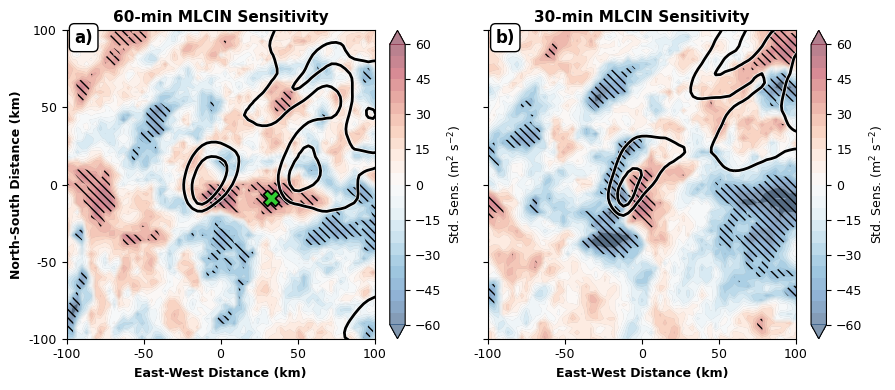

In [5]:

wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

################################# Define figure and plot ##########################################

fig, axs = plt.subplots(1, 2,figsize=(9,4))
axs = axs.flatten()

state_times = [state_times[-5],state_times[-3]]

for i, ax in enumerate(axs):

    state_time = state_times[i]
    statevar = statevars[i]

    ############### Process date/time strings and define file names ################
    
    respmin, resphour, respday, respmonth, respyear = resptime[14:16], resptime[11:13], resptime[8:10], resptime[5:7], resptime[0:4]
    str_statemin, str_statehour, str_statemonth = '{:02d}'.format(state_time.minute),'{:02d}'.format(state_time.hour),'{:02d}'.format(state_time.month)
    inityear, initmin, inithour, initday, initmonth = case[0:4], case[10:12], case[8:10], case[6:8], case[4:6]
    
    resp_time = datetime.datetime(int(respyear), int(respmonth), int(respday), int(resphour), int(respmin))
    
    file_ref = f'{wofs_path}/wofs_{inityear}{initmonth}{initday}_{inithour}{initmin}/wofs_center_i{inityear}{initmonth}{initday}{inithour}{initmin}_v{state_time.year}{str_statemonth}{state_time.day}{str_statehour}{str_statemin}.nc'
    file_sens = f'{sens_path}/sens_center_2019{initmonth}{initday}{inithour}{initmin}/stats_{respvar}_max_{resphour}_{respmin}_00_{statevar}_{str_statehour}_{str_statemin}_00.nc'
        
    ############### Open files and define variables from them ################
    
    ds_ref = xr.open_dataset(file_ref)
    ds_sens = xr.open_dataset(file_sens)

    cref = np.where(np.nanmean(ds_ref.REFD_MAX, axis=0) < 10, np.nan, np.nanmean(ds_ref.REFD_MAX, axis=0))[0]
    sens = ds_sens.stdsens
    pstat = abs(ds_sens['pstat'].values)
    
        # remove where sensitivity is infinity
    sens = np.where(sens==9.96921e+36, np.nan, sens)
    
    ############### Define storm-relative grids ################
    
    logging.captureWarnings(True) # capture warnings 
    
    df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)
    
    xmesh,ymesh = cr.xy_mesh(case, state_time)
    
    logging.captureWarnings(False) # turn warnings back on
    
    ############### Plotting code ################
    
    ax.contour(xmesh, ymesh, cref, linewidths=3, levels=[20,35,50], colors='w', alpha=1)
    ax.contour(xmesh, ymesh, cref, linewidths=2, levels=[20,35,50], colors='k')
    ax.contourf(xmesh, ymesh, sens, colors='white', levels=levels, antialiased=True) # prevents dark background from bleeding through
    cb = ax.contourf(xmesh, ymesh, sens, cmap='RdBu_r', levels=levels, extend='both', antialiased=True, alpha=0.5)
    ax.contourf(xmesh, ymesh, pstat, [0, 0.05], colors='none', hatches=['\\\\\\\\'], extend='lower')
    
    ax.set_facecolor('darkgrey') # make axis background gray
    
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    
    ########## Axis decoration specs ##########
    
    statevar = statevar.replace('-', '_')
    
    xticks, yticks = np.arange(-100,101,50), np.arange(-100,101,50)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xlabel('East-West Distance (km)', size=9, weight='bold')
    ax.set_xticklabels(xticks, size=9)
    
    if i == 0:
        ax.set_ylabel('North-South Distance (km)', size=9, weight='bold')
        ax.set_yticklabels(yticks, size=9)
    if i == 1:
        ax.set_yticklabels([])
    
    #if (i % 2) == 0: # if divisible by 2
    #    ax.set_ylabel('North-South Distance (km)', size=10)
    #    ax.set_yticklabels(yticks, size=9)
    #else:
    #    ax.set_yticklabels([])
    
    if i == 0:
        ax.set_title(f'60-min {statevar} Sensitivity', size=11, weight='bold')
    if i == 1:
        ax.set_title(f'30-min {statevar} Sensitivity', size=11, weight='bold')
    
    ax.text(0.025, 0.96, axlabels[i], color='k',
        bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax.transAxes, 
        size=12, weight='bold')
    
axs[0].scatter(33,-9, marker='X', s=130, edgecolor='k', lw=1.2, c='limegreen')

    ########## Colorbar specs ##########

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout() # make sure tight_layout() comes before defining colorbar

for ax in axs:
    cbar = plt.colorbar(cb, ax=ax, pad=0.04)
    cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=9)
    cbar.ax.tick_params(labelsize=9)
    
#plt.suptitle(f'Sensitivity of {respvar} at {int((resp_time - state_time).seconds/60)}-min lead time', weight='bold')

    ########## Save statement ##########

if save == True:
    plt.savefig(f'{outplot_path}/stdsens_{case}_{statevars[0]}_{statevars[1]}.jpg', bbox_inches='tight', facecolor='w', dpi = 200)

plt.show()